In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [3]:
path = f"{root}/09_18_23_BinaryPetsPilot"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

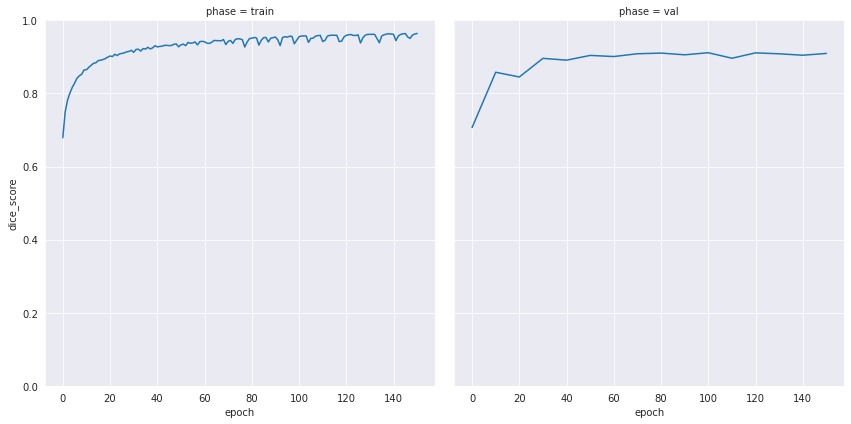

In [5]:
best_exp.vis_loss_curves(height=6)

In [6]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.BinaryPets
split: cal
preload: True
version: 0.1

<IPython.core.display.Javascript object>

In [7]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
BinaryPet_Dataset = dataset_cls(**dataset_cfg)
binarypets_dataloader = DataLoader(BinaryPet_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
from ionpy.util.torchutils import to_device
import torch
from tqdm.notebook import tqdm

def get_dataset_perf(
        exp, 
        dataloader, 
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            # Get the prediction
            yhat = exp.model(x)  
            # Extract predictions
            soft_pred = torch.softmax(yhat, axis=1)
            hard_pred = torch.argmax(soft_pred, axis=1)
            # Get the confidence map
            conf_map = torch.max(soft_pred, axis=1)[0]
            # Wrap it in an item
            items.append({
                "image": x.cpu().squeeze(),
                "label": y.cpu().squeeze(),
                "conf_map": conf_map.cpu().squeeze(),
                "pred_map": hard_pred.cpu().squeeze(),
            })

    return items

In [9]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_list = get_dataset_perf(
    exp=best_exp, 
    dataloader=binarypets_dataloader
    )

  0%|          | 0/737 [00:00<?, ?it/s]

In [10]:
%%yaml metric_cfg 

ECE:
    func: ese.experiment.metrics.pixelwise.ECE
    color: blue
ACE:
    func: ese.experiment.metrics.pixelwise.ACE
    color: goldenrod
Island_ECE:
    func: ese.experiment.metrics.pixelwise.Island_ECE 
    color: lightgreen 
ReCE:
    func: ese.experiment.metrics.regionwise.ReCE
    color: green

<IPython.core.display.Javascript object>

ValidationError: 2 validation errors for Rece
label
  field required (type=value_error.missing)
kwargs
  unexpected keyword argument: 'label_map' (type=type_error)

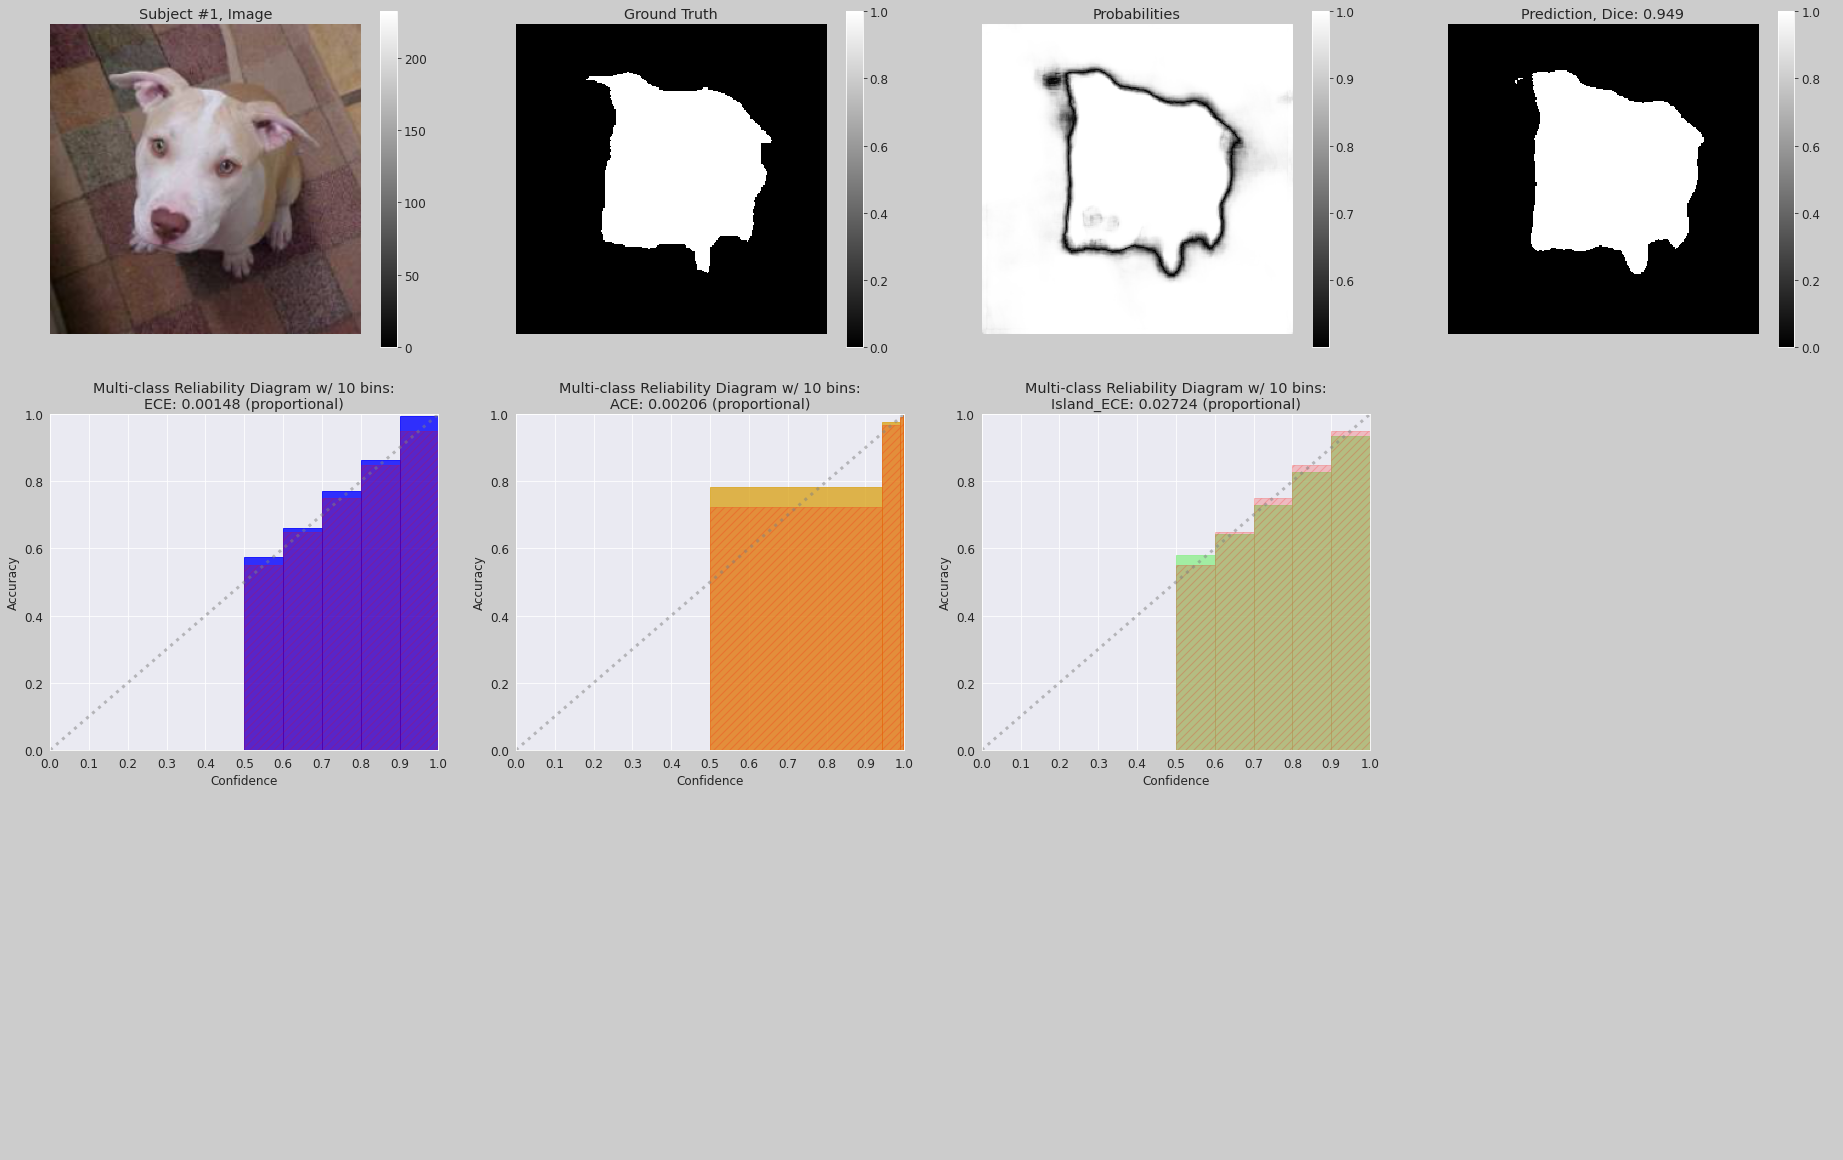

In [11]:
from ese.experiment.analysis.diagrams import subject_diagram

subject_diagram(
    num_subjects=10,
    subject_list=predictions_list,
    num_bins=10,
    class_type="Multi-class",
    metric_cfg=metric_cfg,
    bin_weighting="proportional",
    show_analysis_plots=False
)

In [ ]:
from ese.experiment.analysis.diagrams import score_histogram_diagram 

score_histogram_diagram(
    subject_list=predictions_list,
    num_bins=10,
    metrics=["ECE", "ReCE"],
    class_type="Multi-class",
    bin_weighting="proportional",
)

In [ ]:
from ese.experiment.analysis.diagrams import score_histogram_diagram 

score_histogram_diagram(
    subject_list=predictions_list,
    num_bins=10,
    metrics=["ECE", "ReCE"],
    bin_weighting="proportional",
)